# Magnetic Susceptibility differences and Iron gene expression levels in GTS.

* Objective is to examine association between Striatal Magnetic Susceptibility statistical maps and the expression of iron-related gene-sets. 
<br><br>

* Analysis driven by         
    * **Romme, Biological Psychiatry, 2017:** Connectome Disconnectivity and Cortical Gene Expression in Patients With Schizophrenia
    * **Whitaker, PNAS, 2016:** Adolescence is associated with genomically patterned consolidation of the hubs of the human brain connectome.
    * **Wong, Cerebral Cortex, 2017:** Inter-Regional Variations in Gene Expression and Age-Related Cortical Thinning in the Adolescent Brain
    * **Shin, Cerebral Cortex, 2016:** Cell-Specific Gene-Expression Profiles and Cortical Thickness in the Human Brain
    * **Romero-Garcia, OHBM, 2017:** Gene expression analysis of structural cortical differences in autism
    * **Richiardi, Science, 2015:** Correlated gene expression supports synchronous activity in brain networks




In [1]:
%matplotlib inline
import os
import math 
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.decomposition import TruncatedSVD, PCA
from matplotlib.colors import rgb2hex
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999

sns.set_style('white')
ahba_dir     = '/scr/malta3/workspace/project_iron/AHBA'
ahba_dir     = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/SEPT10/AHBA/'
ahba_dir2     = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/AUG27/AHBA/'
save_fig_dir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'

drop_strings = ['coords_native', 'donor_names', 'struct_id', 
                'struct_name', 'top_struct', 'Mean', 'Median', 
                'PC1', 'PC2','PC3', #'SVD1g', 'SVD2g','SVD3g', 'SVD3p', 'SVD2p','SVD3p', 
                'corrected_mni_x', 'corrected_mni_y', 'corrected_mni_z']

import warnings
warnings.filterwarnings('ignore')

# quality control
# drop wells outside the striatal masks 
drop_wells = [2371, 13913, 2379, 127687508]


# Lets be colour-full 

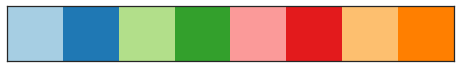

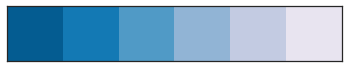

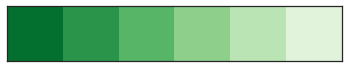

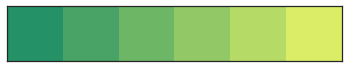

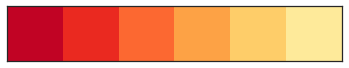

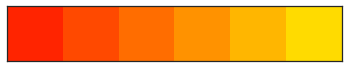

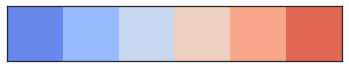

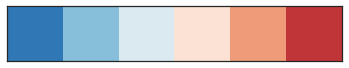

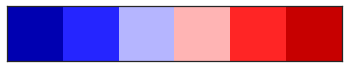

In [2]:
# colours
P = sns.color_palette("Paired",8)
B = sns.color_palette("PuBu_r")
G = sns.color_palette("Greens_r")
R = sns.color_palette("YlOrRd_r")
S = sns.color_palette("summer")
A = sns.color_palette("autumn")
C = sns.color_palette("coolwarm")
D = sns.color_palette("RdBu_r")

sns.palplot(P)
sns.palplot(B)
sns.palplot(G)
sns.palplot(S)
sns.palplot(R)
sns.palplot(A)
sns.palplot(C)
sns.palplot(D)
sns.palplot(sns.color_palette("seismic"))

# Geneset contents

In [3]:
##################################################################################################
# Genesets 
##################################################################################################

GS_IRON_H   = ['FTH1','FTL' ,'HFE','HFE2','IL1A', 'IL6', 'IL6R','IREB2','SLC40A1','TF','TFR2','TNF',]
GS_IRON_D = ['THRSP', 'TF', 'MAL', 'KLK6', 'HOMER1', 'MOBP', 'APOD', 'MOG', 'CRYAB', 'APOC1', 'CA2', 'RASGRP1', 
          'STMN4', 'LYZ','GSTM1', 'CTSS',  'DCK' ]

GS_IRON_IH = ['ABCB6', 'ABCB7', 'ABCG2', 'ACO1', 'ALAS2', 'BMP6', 'CP', 'CYBRD1',  'FLVCR1', 'FTH1',  'FTHL17',
                        'FTL', 'FTMT', 'FXN', 'GDF2', 'HAMP', 'HEPH', 'HFE', 'HFE2', 'HIF1A', 'HMOX1', 'HMOX2', 'HPX', 'IREB2', 'ISCU', 'LCN2',
                        'LTF', 'MYC', 'NDFIP1', 'NUBP1', 'SCARA5', 'SLC11A1', 'SLC11A2', 'SLC22A17', 'SLC40A1', 'SLC46A1', 'SMAD4', 'SOD1',
                        'SRI', 'TF', 'TFR2', 'TFRC', 'TMPRSS6', 'TTC7A']

GS_IRON_IM = ['HFE', 'MFI2', 'PICALM', 'SLC11A2', 'STEAP1', 'STEAP1B', 'STEAP2', 'STEAP3', 'STEAP4', 'TF', 
              'TFR2', 'TFRC']

GS_IRON_T1 = ['ABCB6', 'ABCB7', 'ABCG2', 'FLVCR1', 'FLVCR2', 'HPX', 'HRG', 'LCN2',
                   'SLC22A17', 'SLC46A1', 'SLC48A1']
GS_IRON_T2 = ['ABCG2', 'ATP6V0A2', 'ATP6V0A4', 'ATP6V0B', 'ATP6V0C', 'ATP6V0D1', 'ATP6V0D2', 'ATP6V0E1', 'ATP6V1A',
              'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2', 'ATP6V1F', 'ATP6V1G1',
              'ATP6V1G2', 'ATP6V1G3', 'ATP6V1H', 'CP', 'CYBRD1', 'FLVCR1', 'FTH1', 'FTL', 'HEPH', 'HMOX1', 'HMOX2',
              'MCOLN1', 'SLC40A1', 'SLC46A1', 'STEAP3', 'TCIRG1', 'TF', 'TFRC']

GS_IRON_R = ['ABAT', 'ABCG2', 'ACO1', 'ALAD', 'APBB1', 'ATP7A', 'B2M', 'BCL2', 'BMP6', 'C1QA', 'CCNB1', 'CCND1',
             'CPOX', 'CYBRD1', 'CYP1A1', 'DRD2', 'FXN', 'GSK3B', 'HAMP', 'HFE', 'HMOX1', 'LCT', 'MDM2', 'PAWR',
             'PDX1', 'SLC11A2', 'SLC40A1', 'SLC6A3', 'SNCA', 'TF', 'TFAP2A', 'TFF1', 'TFR2', 'TFRC', 'UROD']



GS_DA     = ['COMT', 'DDC', 'MAOA', 'MAOB', 'NQO1', 'PPP2CA', 'PPP2CB', 'PRKACA', 'PRKACB','PRKACG', 'TH', 'TYR']
GS_DA_receptor_bind = ['GNA13', 'DLG4', 'DNM1', 'DNM2','DRD1', 'DRD3','GNA12','GNAS',  'ARRB2', 'ATP1A3', 'PALM', 
                    'CLIC6', 'PTPN11', 'PPP1R1B', 'DNAJC14', 'CAV2', 'SLC9A3R1']
GS_DA_receptor_sig  = ['ADCY5', 'ADCY6', 'ARRB2', 'CALY','DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'FLNA', 
                   'GNA11', 'GNA14', 'GNA15', 'GNAI3', 'GNAL', 'GNAO1', 'GNAQ', 'GNAS', 'GNB1', 'GNG2', 
                   'GPR21', 'GPR52', 'GSK3A', 'GSK3B', 'HMP19', 'KLF16', 'OPRM1', 'RGS9', 'SLC9A3R1']
GS_DA_transport     = ['CHRM5','DRD1','PARK2','PARK7','SLC18A2','SLC22A1','SLC22A2','SLC22A3', 'SLC6A2',
                    'SLC6A3','SNCA']
GS_DA_transmission  = ['CDK5','CRH','CRHBP','DRD1','DRD2','DRD3','DRD4','DRD5','RASD2','TH']
GS_ANMC = ['ME1', 'ALDH5A1', 'GBE1', 'GALM', 'PYGL', 'CPS1','PFKFB3', 'PYGB', 'IDH2', 'ENO1','PPP1R1A', 
        'MDH2', 'CS','PYGM', 'PGM3', 'PHKG1', 'SLC3A2', 'PFKFB4', 'KHK','LDHB', 'PCK2','SLC2A8',  'PGM2', 
        'GPT','AKR1B1', 'NANS', 'PDK4','OGDHL','DHTKD1', 'PFKM', 'PGM1', 'PC','AGL']
GS_GLU  = ['UNC13B', 'RIMS1', 'GLS2', 'GLS', 'SLC38A2', 'SLC17A7', 'RAB3A', 'SLC1A1', 'SLC1A6', 'SLC1A7', 
        'SNAP25', 'STX1A', 'STXBP1','VAMP2', 'SYT1' ]
GS_GABA = ['GPHN', 'GABARAP','DNM1', 'GABRA1', 'GABRA2', 'GABRA3', 'GABRA4','GABRA5','GABRA6''SRC'] 
GS_GABA_GLU = GS_GLU + GS_GABA
GS_TF       = ['TF']
GS_FTH      = ['FTH1']
GS_FTL      = ['FTL']
GS_HRE      = ['HFE']
GS_HRE2     = ['HFE2']
GS_SLC25    = ['SLC25A37']
GS_SLC40    = ['SLC40A1']
GS_BIOBANK  = GS_TF + GS_FTH + GS_HRE + GS_SLC25
GS_FTH_ALL  = ['FTH1', 'FTH1P14', 'FTH1P20', 'FTHL17' ]
GS_FTL_ALL  = ['FTL', 'FTLP17']
GS_FERRITIN = GS_FTH_ALL + GS_FTL_ALL + ['FTMT']

GS_TCA = ['ACLY', 'ACO1', 'ACO2', 'CS', 'DLAT', 'DLD', 'DLST', 'FH', 'IDH1', 'IDH2', 'IDH3A', 'IDH3B',
      'IDH3G', 'LOC283398', 'LOC642502', 'MDH1', 'MDH2', 'OGDH', 'OGDHL', 'PC',  'PCK1',  'PCK2',
     'PDHA1', 'PDHA2', 'PDHB', 'SDHA', 'SDHB', 'SDHC', 'SDHD', 'SUCLA2', 'SUCLG1', 'SUCLG2']

GS_BTBD9 = ['BTBD9']
GS_ACO1 = ['ACO1']
GS_ACO2 = ['ACO2']
GS_ACO =  GS_ACO1+ GS_ACO2

# Read Geneset Expression Values
* Each dataframe contrains expression values from each sampling well, total wells = 3702 
* Each Well corresponds to an MNI coordinate
* For each gene, expression was calculate as the average of all probes
* 5 principal components were also extracted for each geneset of interest (IRON,IRON_D,ANMC)

In [4]:
def return_expression_df(geneset):
    return pd.read_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset),index_col=0)

IRON_H           = return_expression_df('IRON_HOMEOSTASIS_PCA')
IRON_D           = return_expression_df('IRON_D_PCA')
IRON_IH          = return_expression_df('IRON_ION_HOMEOSTASIS_PCA')
IRON_IM          = return_expression_df('IRON_ION_IMPORT_PCA')
IRON_IB          = return_expression_df('IRON_ION_BINDING_PCA')
IRON_T1          = return_expression_df('IRON_TRANSPORT1_PCA')
IRON_T2          = return_expression_df('IRON_TRANSPORT2_PCA')
IRON_R           = return_expression_df('IRON_RESPONSE_PCA')
ANMC             = return_expression_df('ANMC_PCA')
DA_met           = return_expression_df('DA_metabolism_PCA')
DA_receptor_sig  = return_expression_df('DA_receptor_sig_PCA')
DA_receptor_bind = return_expression_df('DA_receptor_PCA')
DA_transmission  = return_expression_df('DA_tranmission_PCA')
DA_transport     = return_expression_df('DA_transport_PCA')
ANMC             = return_expression_df('ANMC_PCA')
GLU              = return_expression_df('GLU_PCA')
GABA             = return_expression_df('GABA_PCA')
GLU_GABA         = return_expression_df('GLU_GABA_PCA')
FTH_ALL          = return_expression_df('FTH_ALL_PCA')
FERRITIN         = return_expression_df('FERRITIN_PCA')
FTL_ALL          = return_expression_df('FTL_ALL')
TF               = return_expression_df('TF')
FTH              = return_expression_df('FTH')
FTL              = return_expression_df('FTL')
HRE              = return_expression_df('HFE')
HRE2             = return_expression_df('HFE2')
SLC25            = return_expression_df('SLC25')
BIOBANK          = return_expression_df('BIOBANK_PCA')
BTBD9            = return_expression_df('BTBD9') 
TCA              = return_expression_df('TCA_PCA') 
ACO              = return_expression_df('ACO') 
ACO1             = return_expression_df('ACO1') 
ACO2             = return_expression_df('ACO2') 
HOUSEKEEPING     = return_expression_df('HOUSEKEEPING') 
HOUSEKEEPING_E   = return_expression_df('HOUSEKEEPING_EISENBERG') 

# Read QSM statistical map (represents susceptibility [iron] differences)
* The statistical maps represents susceptibility differences between Healthy controls (N=26) and GTS patients (N=23).
* Maps were calculated with a two sample t-test using 10,000 permutations,threshold- free cluster enhancement, and FWE correction.
* ROIs include L/R_Caud, L/R_Putamen, L/R_Pallidum, STR3_MOTOR, STR3_EXEC, STR3_LIMBIC

In [5]:
df_MNI = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_SEPT10.csv'), index_col = 0 )

# Concatenate Dataframes

In [6]:
def concat_dfs(measure):
    df  = pd.DataFrame(index = IRON_H.index, 
                        columns = ['IRON', 'IRON_D', 'DA_met', 'DA_receptor_bind', 'DA_receptor_sig', 
                                   'DA_transmission', 'DA_transport', 'ANMC', 'GLU', 'GABA', 'GLU_GABA', 
                                   'TF', 'FTH', 'FTL', 'HRE', 'HRE2', 'SLC25', 'SLC40', 'BIOBANK',
                                   'BTBD9', 'TCA', 'ACO','ACO1', 'ACO2', 'HOUSEKEEPING', 'HOUSEKEEPING_E',
                                   'top_struct', 'struct'])
    xval = 1
    df['top_struct']        = IRON_H.top_struct
    df['struct']            = IRON_H.struct_name
    df['IRON_H']            = IRON_H[measure] * xval
    df['IRON_D']            = IRON_D[measure]
    df['IRON_IH']           = IRON_IH[measure] * xval
    df['IRON_IM']           = IRON_IM[measure] * xval
    df['IRON_IB']           = IRON_IB[measure] * xval
    df['IRON_T1']           = IRON_T1[measure] * xval
    df['IRON_T2']           = IRON_T2[measure] * xval
    df['IRON_R']            = IRON_R[measure] * xval
    df['DA_met']            = DA_met[measure] * xval
    df['DA_receptor_bind']  = DA_receptor_bind[measure] * xval
    df['DA_receptor_sig']   = DA_receptor_sig[measure] * xval
    df['DA_transmission']   = DA_transmission[measure] * xval
    df['DA_transport']      = DA_transport[measure] * xval
    df['ANMC']              = ANMC[measure] * xval
    df['GLU']               = GLU[measure] * xval
    df['GABA']              = GABA[measure] * xval
    df['GLU_GABA']          = GLU_GABA[measure] * xval
    df['FTH_ALL']           = FTH_ALL[measure] * xval    
    df['FERRITIN']          = FERRITIN[measure] * xval    
    df['TCA']               = TCA[measure] * xval    
    if measure not in ['PC1', 'PC2', 'PC3', 'SVD1g','SVD2g', 'SVD3p', 'SVD1p','SVD2p', 'SVD3p']: 
        df['FTL_ALL']           = FTL_ALL[measure] * xval    
        df['TF']                = TF['TF'] * xval
        df['FTH']               = FTH['FTH1'] * xval
        df['FTH1P14']           = FERRITIN['FTH1P14'] * xval    
        df['FTH1P20']           = FERRITIN['FTH1P20'] * xval    
        df['FTHL17']            = FERRITIN['FTHL17'] * xval    
        df['FTL']               = FTL['FTL'] * xval
        df['HFE']               = HRE['HFE'] * xval
        df['HFE2']              = HRE2['HFE2'] * xval
        df['SLC25']             = SLC25['SLC25A37'] * xval
        df['BTBD9']             = BTBD9['BTBD9'] * xval
        df['ACO']               = ACO[measure] * xval
        df['ACO1']              = ACO1['ACO1'] * xval
        df['ACO2']              = ACO2['ACO2'] * xval
        df['BIOBANK']           = BIOBANK[measure] * xval
        df['HOUSEKEEPING']      = HOUSEKEEPING[measure] * xval
        df['HOUSEKEEPING_E']    = HOUSEKEEPING_E[measure] * xval
    dfc = pd.concat([df_MNI, df], axis = 1)
    return dfc

df_SVD1g  = concat_dfs('SVD1g')
df_SVD2g  = concat_dfs('SVD2g')
df_SVD1p  = concat_dfs('SVD1p')
df_SVD2p  = concat_dfs('SVD2p')
#df_SVD3  = concat_dfs('SVD3')
df_PC1   = concat_dfs('PC1')
df_PC2   = concat_dfs('PC2')
df_PC3   = concat_dfs('PC3')
df_MU    = concat_dfs('Mean')

# Fixed Effect Correlations

In [7]:
rois = ['Caud',
        'Puta',
        'STR3_MOTOR', 
        'STR3_EXEC', 
        'STR3_LIMBIC', 
       ]

def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])
    outliers = []
    for subject in df.index:
        if df.loc[subject][measure] > upper:
            outliers.append(subject) 
        elif df.loc[subject][measure] < lower:
            outliers.append(subject) 
    #print outliers,measure
    return outliers

def make_corr(DF, met1,met2, color, annotate=0):
    DF = DF
    dfx = pd.DataFrame(index=DF.index)
    dfx[met1]  = DF[met1]  * 10
    dfx[met2]  = DF[met2]
    
    dfx = dfx.drop([2371, 13913, 2379, 127687508],axis=0).dropna()
    r_val = np.round(pearsonr(dfx[met1], dfx[met2])[0],2)
    p_val = np.round(pearsonr(dfx[met1], dfx[met2])[1],10)
    #print len(dfx), r_val, p_val

    if p_val < 0.1:
        print met1, met2[0:6], r_val, p_val
        grid = sns.JointGrid(met1, met2, data=dfx)#,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
        grid.plot_marginals(sns.distplot, color = color, hist=0, kde = 1, kde_kws={'shade':1})
                            #rug = 1, rug_kws = {'height':0.1})  
        grid.plot_joint(sns.regplot, fit_reg=1, scatter= 1, color = color)#, 
                    #ci = 95, line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
        #sns.jointplot(met1, met2,dfx, kind = 'reg', color=color)
        #plt.vlines(0,5,7.5)
        #plt.set_axis_labels()
        #if annotate:
        #    plt.annotate('R=%s, P=%s' %(r_val, p_val), xy = annotate, fontsize = 13,  color='r')
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(fontsize=12, weight='bold')
        plt.yticks(fontsize=12, weight='bold')
        #plt.ylim(-.5,1.5)
        #plt.xlim(-30,50)
        plt.savefig(os.path.join(save_fig_dir, 'gorter_corr_%s_%s.png' %(met1,met2)), dpi = 300,
                    bbox_inches='tight', transparent = True)
        
    return dfx


IRON_T2 STR3_M 0.35 0.0051191362


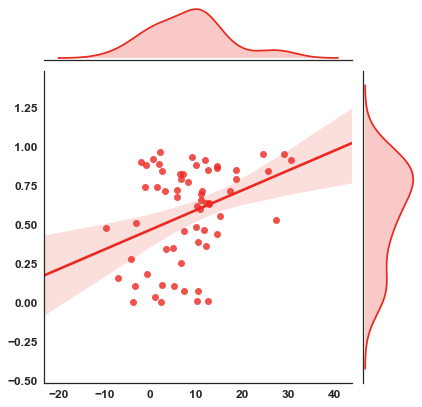

In [8]:
for roi in ['STR3_MOTOR']:
    #dfx_iron_h  = make_corr(df_PC1,'IRON_H', '%s_tfce_corrp_tstat_CP_2'%roi,B[1], (0.14,1.4))
    #dfx_iron_d  = make_corr(df_PC1,'IRON_D', '%s_tfce_corrp_tstat_CP_2'%roi,G[1], (0.14,1.4))
    dfx_ferr = make_corr(df_PC1,'IRON_T2', '%s_tfce_corrp_tstat_CP_2'%roi,R[1], (65,1.4))
    #dfx_ferr = make_corr(df_PC1,'FERRITIN', '%s_tfce_corrp_tstat_CP_2'%roi,A[1], (65,1.4))
    #dfx_tf = make_corr(df_MU,'TF', '%s_tfce_corrp_tstat_CP_2'%roi,R[3], (65,1.4))


IRON_H STR3_M 0.39 0.0017513571
IRON_D STR3_M 0.46 0.0001475414
FERRITIN STR3_M 0.5 3.3031e-05


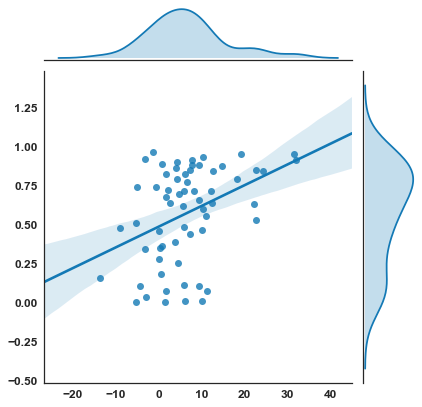

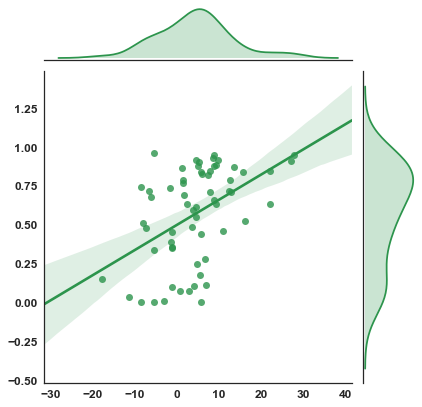

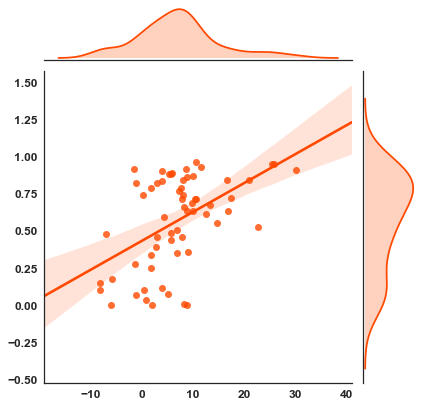

In [9]:
for roi in ['STR3_MOTOR']:
    dfx_iron_h  = make_corr(df_PC1,'IRON_H', '%s_tfce_corrp_tstat_CP_2'%roi,B[1], (0.14,1.4))
    dfx_iron_d  = make_corr(df_PC1,'IRON_D', '%s_tfce_corrp_tstat_CP_2'%roi,G[1], (0.14,1.4))
    dfx_ferr = make_corr(df_PC2,'IRON_T2', '%s_tfce_corrp_tstat_CP_2'%roi,R[1], (65,1.4))
    dfx_ferr = make_corr(df_PC1,'FERRITIN', '%s_tfce_corrp_tstat_CP_2'%roi,A[1], (65,1.4))
    #dfx_tf = make_corr(df_MU,'TF', '%s_tfce_corrp_tstat_CP_2'%roi,R[3], (65,1.4))


ANMC STR3_M 0.27 0.0337759606


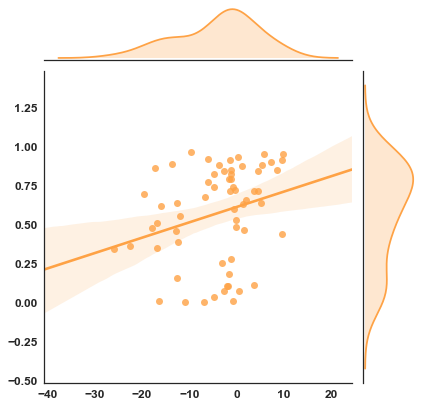

In [10]:
for roi in ['STR3_MOTOR']:
    x = make_corr(df_PC1,'ANMC', '%s_tfce_corrp_tstat_CP_2'%roi,R[3], (65,1.4))


ANMC STR_tf 0.17 0.0596381316


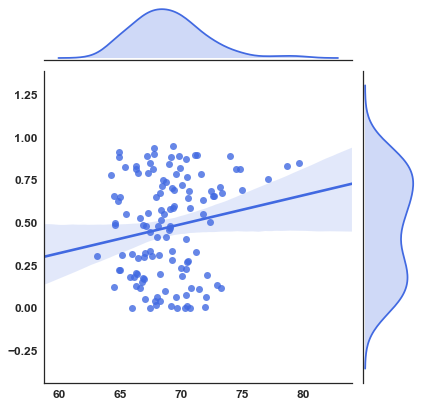

In [11]:
for roi in ['STR']:
    dfx_iron_h  = make_corr(df_MU,'ANMC', '%s_tfce_corrp_tstat_CP_2'%roi, 'royalblue', (0.14,1.4))
    #dfx_iron_d  = make_corr(df_PC1,'IRON_D', '%s_tfce_corrp_tstat_CP_2'%roi,'royalblue', (0.14,1.4))


In [12]:
from glob import glob
import os
import pandas as pd
import numpy as np
import nibabel as nb
import numpy.linalg as npl

def get_sphere(coords, r, vox_dims, dims):
    """ # Return all points within r mm of coordinates. Generates a cube
    and then discards all points outside sphere. Only returns values that
    fall within the dimensions of the image."""
    r = float(r)
    xx, yy, zz = [slice(-r / vox_dims[i], r / vox_dims[
                        i] + 0.01, 1) for i in range(len(coords))]
    cube = np.vstack([row.ravel() for row in np.mgrid[xx, yy, zz]])
    sphere = cube[:, np.sum(np.dot(np.diag(
        vox_dims), cube) ** 2, 0) ** .5 <= r]
    sphere = np.round(sphere.T + coords)
    return sphere[(np.min(sphere, 1) >= 0) & (np.max(np.subtract(sphere, dims), 1) <= -1),:].astype(int)

def get_values_at_locations(nifti_file, locations, radius, mask_file=None,  verbose=False):
    values = []
    nii = nb.load(nifti_file)
    data = nii.get_data()
    
    if mask_file:
        mask_data = nb.load(mask_file).get_data()
        mask = np.logical_and(np.logical_not(np.isnan(mask_data)), mask_data > 0)
    else:
        if verbose:
            print "No mask provided - using implicit (not NaN, not zero) mask"
        mask = np.logical_and(np.logical_not(np.isnan(data)), data != 0)
        
    for location in locations:
        coord_data = [round(i) for i in nb.affines.apply_affine(npl.inv(nii.get_affine()), location)]
        sph_mask = (np.zeros(mask.shape) == True)
        if radius:
            sph = tuple(get_sphere(coord_data, vox_dims=nii.get_header().get_zooms(),r=radius, dims=nii.shape).T)
            sph_mask[sph] = True
        else:
            #if radius is not set use a single point
            sph_mask[coord_data[0], coord_data[1], coord_data[2]] = True
        
        roi = np.logical_and(mask, sph_mask)
        
        #If the roi is outside of the statmap mask we should treat it as a missing value
        if np.any(roi):
            val = data[roi].mean()
        else:
            val = np.nan
        values.append(val)
    return values

In [13]:
drop = [2371, 13913, 2379, 127687508, 127687121]
nifti_sub_str3m = '/Users/kanaan/SCR/workspace/tmp_randomise/randomise_CP_SUBCORTICAL_tfce_corrp_tstat1_STR_MOTOR_MASKED.nii.gz'

package = '/Users/kanaan/SCR/Github/alleninf/alleninf'
df      = pd.read_csv(os.path.join(package, "data", "corrected_mni_coordinates.csv"), header=0, index_col=0)
df['mni_coords'] = list(zip(df.corrected_mni_x,df.corrected_mni_y,df.corrected_mni_z))

In [14]:
#df['SUB_STR3M'] = get_values_at_locations(nifti_sub_str3m, df['mni_coords'], 1, mask_file=None,  verbose=True)

In [15]:
len(df.SUB_STR3M.dropna())
len(df_MU.STR3_MOTOR_tfce_corrp_tstat_CP_2.dropna())



AttributeError: 'DataFrame' object has no attribute 'SUB_STR3M'

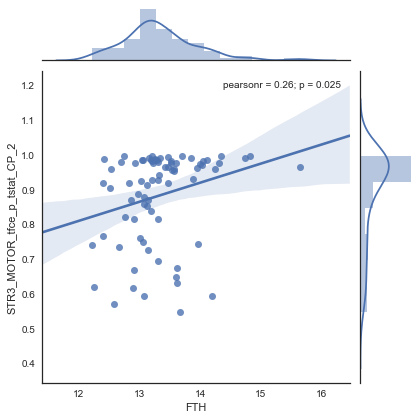

In [19]:
sns.jointplot(df_MU.FTH, df_MU.STR3_MOTOR_tfce_p_tstat_CP_2.drop([2371, 13913, 2371],axis=0), kind = 'reg')

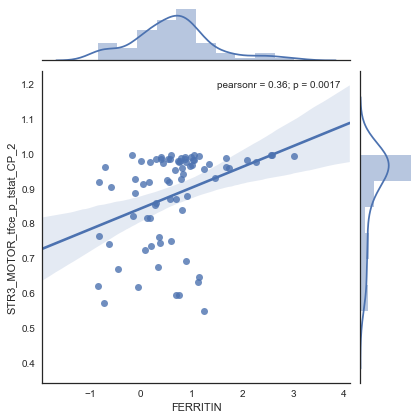

In [16]:
dropi = [2371, 13913, 2379, 127687508, 127687121]
sns.jointplot(df_PC1.FERRITIN, df_MU.STR3_MOTOR_tfce_p_tstat_CP_2.drop(dropi,axis=0), kind = 'reg')

In [ ]:
dropi = [2371, 13913, 2379, 127687508]
sns.jointplot(df_PC1.IRON_H, df_MU.STR3_MOTOR_tfce_corrp_tstat_CP_2.drop(dropi,axis=0), kind = 'reg')

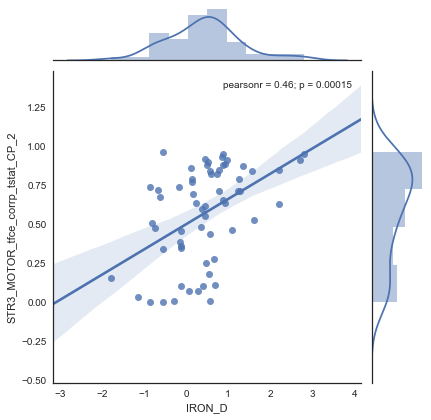

In [24]:
dropi = [2371, 13913, 2379]
sns.jointplot(df_PC1.IRON_D, df_MU.STR3_MOTOR_tfce_corrp_tstat_CP_2.drop(dropi,axis=0), kind = 'reg')

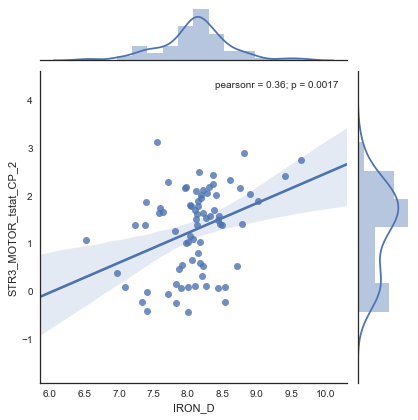

In [103]:
met2 = 'STR3_MOTOR_vox_p_tstat_CP_2'
drop_T = [well for well in dfx.index if df_MU.loc[well][met2] < 0]

dropi = [2371, 13913, 2379, 127687121]
sns.jointplot(df_MU.IRON_D, df_MU.STR3_MOTOR_tstat_CP_2.drop(dropi + drop_T,axis=0), kind = 'reg')

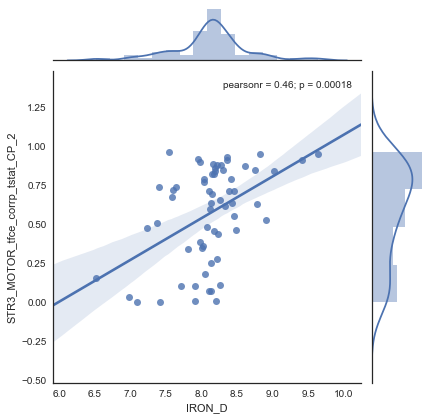

In [100]:
sns.jointplot(df_MU.IRON_D, df_MU.STR3_MOTOR_tfce_corrp_tstat_CP_2.drop(dropi + drop_T,axis=0), kind = 'reg')

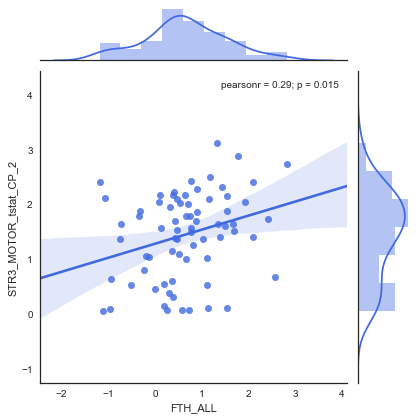

In [83]:
DF = df_PC1

met1= 'STR3_MOTOR_tstat_CP_2'
met2= 'FTH_ALL' #FTH1P14. FTH1P20, FTHL17

dfx = pd.DataFrame(index=DF.index)
dfx[met1]  = DF[met1]
dfx[met2]  = DF[met2]

dfx = dfx.dropna()
drop_T = [well for well in DF.index if DF.loc[well][met1] < 0.0]
drop_x    = [127687121]
dfx = dfx.drop(drop_T + drop_x ,axis=0)
sns.jointplot(met2, met1, dfx, kind = 'reg', color='royalblue')


2371        -1.184754
5929        -1.108881
2379        -1.065092
127687979   -1.053626
13594       -0.962369
5898        -0.932710
127687931   -0.757454
5769        -0.727984
127687915   -0.654617
127687867   -0.504580
13809       -0.354483
14177       -0.344269
159226061   -0.329025
159226107   -0.227061
772         -0.197492
780         -0.122990
893         -0.004318
156434571    0.078791
5738         0.104960
139379756    0.126885
159226045    0.135778
156434555    0.185280
1234         0.192561
13897        0.254589
13665        0.296424
149052726    0.315270
1170         0.360885
159439009    0.362561
4961         0.380858
126432120    0.385757
4906         0.410663
5050         0.425558
5675         0.428895
4938         0.462762
139379739    0.463465
4914         0.481145
156906972    0.498376
4970         0.518525
1171         0.534698
126432136    0.568747
147628277    0.649363
949          0.666194
13905        0.666743
977          0.670180
14169        0.711889
126432517 

In [ ]:
df_MU